## Modèles Atemporel:
### Demande(quantité) par produit par catégorie

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os 
os.environ["ENV"]="LOCAL"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../store_order_service_account"
#print(os.environ) 
os.chdir("/Users/gnabeyeuemmanuel/Desktop/demandEstimate/demand-service")

### 1. Import usefull libraries

In [3]:
import os
import sys
import sys; 
sys.path.insert(0, '..')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, NMF,FastICA,TruncatedSVD,IncrementalPCA
from sklearn.cluster import KMeans
#import pandasgui

%matplotlib inline
import google.cloud.secretmanager as secretmanager

from utils.utility_fct import get_table_sql,cross_product

from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_squared_log_error
from xgboost import plot_importance, plot_tree

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline

import time
import datetime
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(20,10) # for graphs styling
plt.style.use('tableau-colorblind10') # for graph stying

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA, NMF,FastICA,TruncatedSVD,IncrementalPCA
#from french_holidays import get_french_holiday_calendar

2022-06-23 12:57:06,096 — utils.utility_fct — INFO — logging with perso-pierre-ro


### 2. Load and Plot the time series dataset

In [4]:
# load dataset
series = pd.read_csv('/Users/gnabeyeuemmanuel/Desktop/demande.csv', header=0) #index_col=0
#print(values)
#visualize
print(series.columns)
print(series.describe())

series.head()

Index(['product_id', 'store_id', 'date', 'product_count'], dtype='object')
       product_count
count  223518.000000
mean        1.498627
std         1.014533
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        56.000000


,product_id,store_id,date,product_count
0,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,2022-02-03,1
1,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,2022-02-05,1
2,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,2022-02-09,2
3,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,2022-02-10,1
4,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,2022-02-13,2


In [5]:
series['date']=pd.to_datetime(series['date'])
df=pd.date_range(start=series['date'].min(), end=series['date'].max())
df=df.to_frame().rename({0:'date'},axis=1)
df= df.merge(series,on='date', how='left').fillna({'product_count':0}).sort_values('date')
df

,date,product_id,store_id,product_count
0,2022-01-02,5cebfa8d0b259700045dc8ad,5fca2dbdabdffb0004e1d05a,1
627,2022-01-02,603d1475c776ee00150cfc0c,5f898d328fd8fa000492a14d,2
628,2022-01-02,603d1475c776ee00150cfc0c,603ceebac776ee00150cfb2d,3
629,2022-01-02,603d1475c776ee00150cfc0c,603f6417954a0c00152089e6,1
630,2022-01-02,603d1475c776ee00150cfc0c,6051c7cdb7817d00159904fc,1
...,...,...,...,...
222749,2022-06-13,5ed13ffca62e740004df2614,611d387f6304c3001686670f,1
222748,2022-06-13,5ed13ffca62e740004df2614,60a37a5a0ede6e001545b001,1
222747,2022-06-13,5ed13ffca62e740004df2614,60674dc314734e00150c9fa1,3
222753,2022-06-13,5ed13ffca62e740004df2617,5f60c3bbf4ff730004b46600,2


In [6]:
series2= pd.read_csv('/Users/gnabeyeuemmanuel/Desktop/products.csv', header=0)
print(series2.columns)

Index(['product_id', 'sub_category', 'capacity_unit', 'created_at', 'weight',
       'catalog_tags', 'product_image_url', 'is_synced', 'hubspot_id',
       'capacity', 'tags', 'provider_data_by_id', 'full_name', 'updated_at',
       'vat_id_by_country', 'has_expiration', 'airtable_id', 'product_name',
       'information', 'category', 'brand', 'barcode', 'segment', 'vat',
       'end_date', 'milestone', 'next_milestone', 'project_name', 'supplier',
       'cdt', 'tag_list', 'price_reference', 'dlc_theorique', 'cycle',
       'dlc_guarantie', 'tag_1', 'launch_date', 'supplier_product_id', 'pcb',
       'bio', 'ha', 'supplier_product_is_enabled'],
      dtype='object')


In [7]:
df_q=series2.loc[:, ['product_id','category']] 
df_q

,product_id,category
0,5de8c77945f5a4587280e81f,restauration
1,61e56f327d68ea0016180eca,restauration
2,62398db6e8ca840016e83be7,snacking
3,6102780a52618b0015ef7a28,produits_frais
4,6239904b998ea900160a6837,snacking
...,...,...
1667,60e5c6a0350a8200150bd0df,epicerie_salee
1668,604f8d3d2c8aed001502aa3c,epicerie_sucree
1669,60ded5a31fd0870015ac350f,fruits_et_legumes
1670,629f172a10d1ca00166b4843,boissons


In [8]:
df_q2=df.merge(df_q,on='product_id', how='left').fillna({'product_count':0}).sort_values('date')
del(df_q2['store_id'])
df_q2 = df_q2[['date','product_id','category','product_count']]
df_q2

,date,product_id,category,product_count
0,2022-01-02,5cebfa8d0b259700045dc8ad,epicerie_sucree,1
627,2022-01-02,5cebfa8d0b259700045dc8ad,epicerie_sucree,2
628,2022-01-02,5cebfa8d0b259700045dc8ad,epicerie_sucree,2
629,2022-01-02,5cebfa8d0b259700045dc8ad,epicerie_sucree,2
630,2022-01-02,5d0794866885630014681b9a,hygiene_et_maison,1
...,...,...,...,...
222749,2022-06-13,62728f8fe2e13b00164caa25,boissons,1
222748,2022-06-13,62728f8fe2e13b00164caa28,desserts,2
222747,2022-06-13,5f147f0ac22b8d00040e8067,epicerie_salee,1
222753,2022-06-13,62728f8fe2e13b00164caa21,boissons,2


#### création d'une matrice avec une ligne par pas de temps et une colonne par produit/catégorie

In [9]:
table = pd.pivot_table(df_q2, values='product_count', index=['date'],
                    columns=['product_id', 'category'], aggfunc=np.sum, fill_value=0) # nan ou fillna= moyenne de la colonne
table.head()

product_id,5cebfa8d0b259700045dc8aa,5cebfa8d0b259700045dc8ad,5cebfa8d0b259700045dc8b2,5cebfa8d0b259700045dc8b3,5d0794866885630014681b9a,5d0794866885630014681ba4,5d0794866885630014681ba6,5d0794866885630014681bb1,5d0794866885630014681bb2,5d0794866885630014681bb5,...,627289bf62d53900165af033,62728f8fe2e13b00164caa20,62728f8fe2e13b00164caa21,62728f8fe2e13b00164caa22,62728f8fe2e13b00164caa23,62728f8fe2e13b00164caa24,62728f8fe2e13b00164caa25,62728f8fe2e13b00164caa28,6275397c7ea2640016504019,62860141dc844500166fca19
category,epicerie_sucree,epicerie_sucree,epicerie_sucree,epicerie_sucree,hygiene_et_maison,boissons,boissons,boissons,boissons,boissons,...,boissons,produits_frais,boissons,boissons,boissons,boissons,boissons,desserts,snacking,desserts
date,,,,,,,,,,,,,,,,,,,,,
2022-01-02,0,9,0,0,2,3,48,26,18,19,...,0,0,0,0,0,0,0,0,0,0
2022-01-03,0,5,4,1,5,6,50,24,19,11,...,0,0,0,0,0,0,0,0,0,0
2022-01-04,0,1,1,3,4,4,38,11,16,10,...,0,0,0,0,0,0,0,0,0,0
2022-01-05,0,2,0,1,5,1,48,10,18,7,...,0,0,0,0,0,0,0,0,0,0
2022-01-06,0,2,0,1,1,0,40,13,21,8,...,0,0,0,0,0,0,0,0,0,0


#### Principal component analysis: ( PCA sur cette matrice )

Cumulative Variances (Percentage):
[20.66195963 29.01222002 33.42368157 37.14301742 39.07950667 40.70495369
 42.09734543 43.46456539 44.73871056 45.9438112  47.04272041 48.09437455
 49.1364268  50.13202756 51.08686475 52.02513128 52.95479789 53.87422235
 54.75467605 55.60379789 56.43343523 57.25036452 58.06139192 58.83899529
 59.60124367 60.35994558 61.09696428 61.83048457 62.54945615 63.25425936
 63.94921336 64.63008793 65.30189757 65.96443761 66.6224559  67.26207056
 67.89322436 68.51667384 69.12764657 69.72495316 70.31591897 70.90034039
 71.47640957 72.03562254 72.59002295 73.12689818 73.65229461 74.17091407
 74.68130527 75.18925691 75.68280243 76.17556565 76.66100956 77.14293358
 77.62064822 78.08047142 78.53611799 78.9816481  79.42259097 79.85605148
 80.2863678  80.71090075 81.12598606 81.53513113 81.93976889 82.33839264
 82.73486785 83.12083015 83.49709963 83.86618853 84.23084142 84.59068008
 84.94284574 85.28737714]
Number of components: 74


Text(0, 0.5, 'Explained variance (%)')

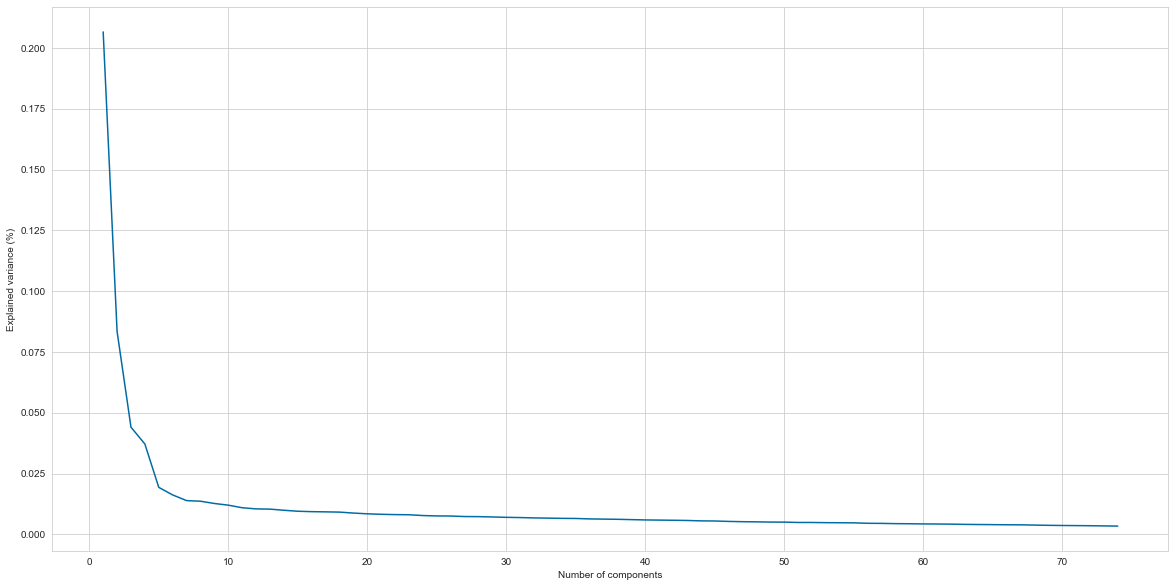

In [10]:
scaler=StandardScaler()
table_scaled=scaler.fit_transform(table)

mypca = PCA(n_components = 0.85)
mypca.fit(table_scaled)
print("Cumulative Variances (Percentage):")
print(np.cumsum(mypca.explained_variance_ratio_ * 100))
components = len(mypca.explained_variance_ratio_)
print(f'Number of components: {components}')
# Make the scree plot
plt.plot(range(1, components + 1), mypca.explained_variance_ratio_ )
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

Text(0, 0.5, 'Explained variance (%)')

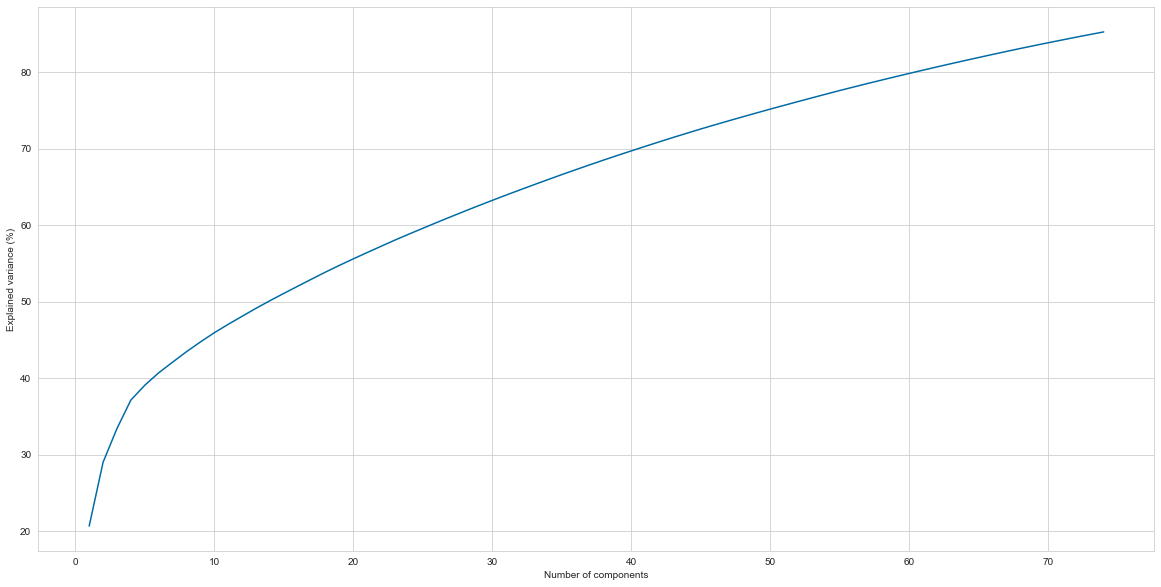

In [11]:
# Make the scree plot
plt.plot(range(1, components + 1), np.cumsum(mypca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

##### And as you can see from the chart, 120 components are needed to cover 85% of the variability in the data:

In [12]:
## diagramme de pareto permet de s'assurer que les composantes retenues retiendront bien la majorité de la variabilité.
def pareto(data) :
    from matplotlib.ticker import PercentFormatter
    y = list(data)
    x = range(len(data))
    ycum = np.cumsum(y)/sum(y)*100
    fig, ax = plt.subplots()
    ax.bar(x,y,color="c")
    ax2 = ax.twinx()
    ax2.plot(x,ycum, color="C1", marker="D", ms=7)
    ax2.axhline(y=80,color="r")
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.tick_params(axis="y", colors="C0")
    ax2.tick_params(axis="y", colors="C1")
    plt.ylim(0,110)
    plt.show()

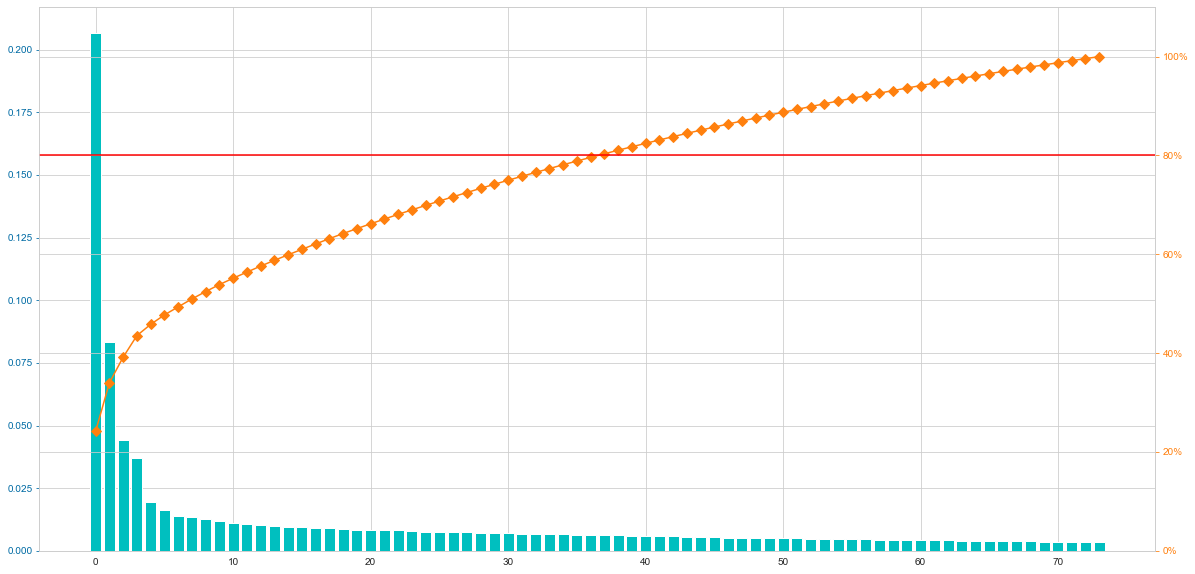

In [13]:
pareto(mypca.explained_variance_ratio_)

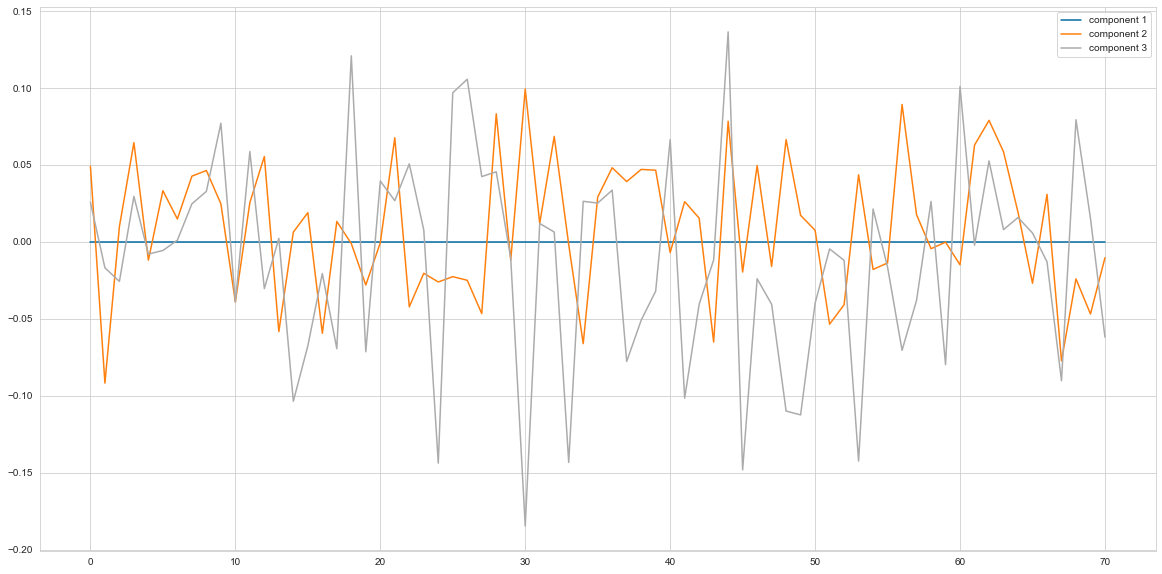

In [159]:
k=0
for comp in mypca.components_.T[:3,:]:
    k+=1
    plt.plot(comp, label=f'component {k}')
plt.legend()

In [15]:
series1 = pd.read_csv('/Users/gnabeyeuemmanuel/Desktop/demande.csv', header=0) #index_col=0
series2 = pd.read_csv('/Users/gnabeyeuemmanuel/Desktop/product_movements.csv', header=0) #.iloc[20:,:] 
print(series2.columns)
series2.head() #,series.tail()]

Index(['store_id', 'product_id', 'start_date', 'end_date'], dtype='object')


,store_id,product_id,start_date,end_date
0,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2020-09-28 17:04:36.809 +0200,2022-06-17 14:17:40.263 +0200
1,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8aa,2020-09-28 17:04:36.809 +0200,2022-06-17 14:17:40.263 +0200
2,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8ad,2020-09-28 17:04:36.809 +0200,2022-06-17 14:17:40.263 +0200
3,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8b1,2020-09-28 17:04:36.809 +0200,2022-06-17 14:17:40.263 +0200
4,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8b2,2020-09-28 17:04:36.809 +0200,2022-06-17 14:17:40.263 +0200


In [16]:
def preprocess(df:pd.DataFrame)->pd.DataFrame:
    df1=pd.DataFrame() 
    #début à partir du 1er janvier 2022   .strftime('%Y-%m-%d')
    ref=datetime.datetime(2022,1,1)
    indexNames = df[df['end_date'] < ref].index
    df.drop(indexNames , inplace=True)
    for i in df.index:
        if df['start_date'][i] < ref:
            df['start_date'][i] = ref
            
    #Dates intermédiaires sur la présence des produits dans le magassin
    df["date"] = df.apply(lambda x: pd.date_range(x.start_date, x.end_date), axis=1)
    df = df.explode('date').reset_index(drop=True)
    df['date']=df['date'].dt.date
        
    return df
    

In [17]:
series2['start_date']= pd.to_datetime(series2['start_date'],utc=True).dt.tz_localize(None)
series2['end_date']= pd.to_datetime(series2['end_date'],utc=True).dt.tz_localize(None)

df_pro=preprocess(series2)
df_pro

,store_id,product_id,start_date,end_date,date
0,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263,2022-01-01
1,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263,2022-01-02
2,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263,2022-01-03
3,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263,2022-01-04
4,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263,2022-01-05
...,...,...,...,...,...
1024943,627e47501f5ac0001658172d,62860141dc844500166fca19,2022-06-03 23:20:53.741,2022-06-17 12:17:40.263,2022-06-13
1024944,627e47501f5ac0001658172d,62860141dc844500166fca19,2022-06-03 23:20:53.741,2022-06-17 12:17:40.263,2022-06-14
1024945,627e47501f5ac0001658172d,62860141dc844500166fca19,2022-06-03 23:20:53.741,2022-06-17 12:17:40.263,2022-06-15
1024946,627e47501f5ac0001658172d,62860141dc844500166fca19,2022-06-03 23:20:53.741,2022-06-17 12:17:40.263,2022-06-16


In [18]:
series1['date'] = pd.to_datetime(series1.date).dt.date
series3=series1.merge(df_pro, how='right', on=['date','store_id','product_id']).fillna({'product_count':0})
series3

,product_id,store_id,date,product_count,start_date,end_date
0,5cebfa8d0b259700045dc8a9,5d5d24216115b3000435fa24,2022-01-01,0.0,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263
1,5cebfa8d0b259700045dc8a9,5d5d24216115b3000435fa24,2022-01-02,0.0,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263
2,5cebfa8d0b259700045dc8a9,5d5d24216115b3000435fa24,2022-01-03,0.0,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263
3,5cebfa8d0b259700045dc8a9,5d5d24216115b3000435fa24,2022-01-04,0.0,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263
4,5cebfa8d0b259700045dc8a9,5d5d24216115b3000435fa24,2022-01-05,0.0,2022-01-01 00:00:00.000,2022-06-17 12:17:40.263
...,...,...,...,...,...,...
1024943,62860141dc844500166fca19,627e47501f5ac0001658172d,2022-06-13,0.0,2022-06-03 23:20:53.741,2022-06-17 12:17:40.263
1024944,62860141dc844500166fca19,627e47501f5ac0001658172d,2022-06-14,0.0,2022-06-03 23:20:53.741,2022-06-17 12:17:40.263
1024945,62860141dc844500166fca19,627e47501f5ac0001658172d,2022-06-15,0.0,2022-06-03 23:20:53.741,2022-06-17 12:17:40.263
1024946,62860141dc844500166fca19,627e47501f5ac0001658172d,2022-06-16,0.0,2022-06-03 23:20:53.741,2022-06-17 12:17:40.263


In [19]:
series3.dtypes

product_id               object
store_id                 object
date                     object
product_count           float64
start_date       datetime64[ns]
end_date         datetime64[ns]
dtype: object

In [20]:
df2=series3.dropna()
df2.drop(df2.columns[[1, 4, 5]], axis = 1, inplace = True) #df.drop(df.loc[:, 'start_date ':'end_date '].columns, axis = 1) 
df2

,product_id,date,product_count
0,5cebfa8d0b259700045dc8a9,2022-01-01,0.0
1,5cebfa8d0b259700045dc8a9,2022-01-02,0.0
2,5cebfa8d0b259700045dc8a9,2022-01-03,0.0
3,5cebfa8d0b259700045dc8a9,2022-01-04,0.0
4,5cebfa8d0b259700045dc8a9,2022-01-05,0.0
...,...,...,...
1024942,62860141dc844500166fca19,2022-06-12,0.0
1024943,62860141dc844500166fca19,2022-06-13,0.0
1024944,62860141dc844500166fca19,2022-06-14,0.0
1024945,62860141dc844500166fca19,2022-06-15,0.0


In [21]:
df_q2=df2.merge(df_q,on='product_id', how='left').fillna({'product_count':0}).sort_values('date')
df_q2 = df_q2[['date','product_id','category','product_count']]
df_q2

,date,product_id,category,product_count
0,2022-01-01,5cebfa8d0b259700045dc8a9,epicerie_sucree,0.0
4032,2022-01-01,5d0794876885630014681bdd,desserts,0.0
505865,2022-01-01,5ec3edb3bb5c330004014836,epicerie_sucree,0.0
193200,2022-01-01,5ebeb6c8dae8ef00043c366f,epicerie_salee,0.0
114540,2022-01-01,5ebeb6c8dae8ef00043c366f,epicerie_salee,0.0
...,...,...,...,...
150135,2022-06-17,5d0794876885630014681bcc,restauration,0.0
15623,2022-06-17,5ec3ee7bbb5c330004014839,snacking,0.0
857163,2022-06-17,618bfaae48ced10016f399dc,restauration,0.0
150519,2022-06-17,5d83268bd8dd27c229979abf,hygiene_et_maison,0.0


#### PCA sur series3/df_q2 par produit/catégorie
#### création d'une matrice avec une ligne par pas de temps et une colonne par produit/catégorie

In [43]:
table2 =pd.pivot_table(df_q2, values='product_count', index=['date'],
            columns=['product_id', 'category'], 
            aggfunc=np.sum ) #, fill_value=0) # nan ou fillna= moyenne de la colonne

filtered_df = table2.query(' table2 == NAN')

In [44]:
# fillna() On = 'average quantity of each product over the 6 months'
tab=df.loc[:, ['product_id', 'product_count']].groupby('product_id').mean()
filler = pd.DataFrame(index = table2.index, columns = table2.columns)


In [45]:
d1 = tab.to_dict()['product_count']
for categorie in filler.columns[1]:
    for id_produit in d1.keys():
        filler[(id_produit,categorie)]=d1[id_produit] 
filler=filler.fillna(0)   
# La version suivante ne marche pas....
#for id_product in tab.index:
 #   for categorie in df_q2['category']:
  #      filler[(id_product,categorie)]=tab.loc[id_produit, 'product_count'] 

In [46]:
table2=table2.fillna(filler)
table2.head()

product_id,5cebfa8d0b259700045dc8a9,5cebfa8d0b259700045dc8aa,5cebfa8d0b259700045dc8ad,5cebfa8d0b259700045dc8b1,5cebfa8d0b259700045dc8b2,5cebfa8d0b259700045dc8b3,5cebfa8d0b259700045dc8b6,5cebfa8d0b259700045dc8bb,5cebfa8d0b259700045dc8be,5d0794866885630014681b95,...,62728f8fe2e13b00164caa20,62728f8fe2e13b00164caa21,62728f8fe2e13b00164caa22,62728f8fe2e13b00164caa23,62728f8fe2e13b00164caa24,62728f8fe2e13b00164caa25,62728f8fe2e13b00164caa28,6275397c7ea2640016504019,62860141dc844500166fca19,629f00f8c4561c00169c78db
category,epicerie_sucree,epicerie_sucree,epicerie_sucree,epicerie_sucree,epicerie_sucree,epicerie_sucree,epicerie_sucree,epicerie_sucree,epicerie_sucree,hygiene_et_maison,...,produits_frais,boissons,boissons,boissons,boissons,boissons,desserts,snacking,desserts,desserts
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-02,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-03,0.0,0.0,5.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-04,0.0,0.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-05,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
scaler=StandardScaler()
table_scaled=scaler.fit_transform(table2)

In [49]:
mypca = PCA(n_components = 0.85)
mypca.fit(table_scaled)
print("Cumulative Variances (Percentage):")
print(np.cumsum(mypca.explained_variance_ratio_ * 100))
components = len(mypca.explained_variance_ratio_)
print(f'Number of components: {components}')

Cumulative Variances (Percentage):
[20.65823575 28.76630866 35.59578552 39.20524902 41.4137078  43.11663317
 44.4976915  45.81211396 47.0810617  48.2674942  49.33725061 50.38298361
 51.39701306 52.36218495 53.31026967 54.22148715 55.12624701 55.99628598
 56.85350775 57.68536236 58.50243757 59.29517671 60.06242932 60.81938173
 61.55234401 62.28352338 63.00649718 63.71507243 64.39804568 65.07365089
 65.74579205 66.39795301 67.03819688 67.67065396 68.2925904  68.90870264
 69.50723895 70.0972484  70.68168851 71.26349385 71.82302169 72.37338241
 72.90890226 73.44110949 73.96785341 74.48482585 74.99046247 75.48246957
 75.97376196 76.4574695  76.92913274 77.39324668 77.84976926 78.30531557
 78.75280551 79.1950683  79.63572786 80.0601372  80.47424425 80.88431924
 81.2894749  81.68884048 82.08223035 82.47219708 82.85835142 83.2387977
 83.60985743 83.97662224 84.33563386 84.68903137 85.03988613]
Number of components: 71


Text(0, 0.5, 'Explained variance (%)')

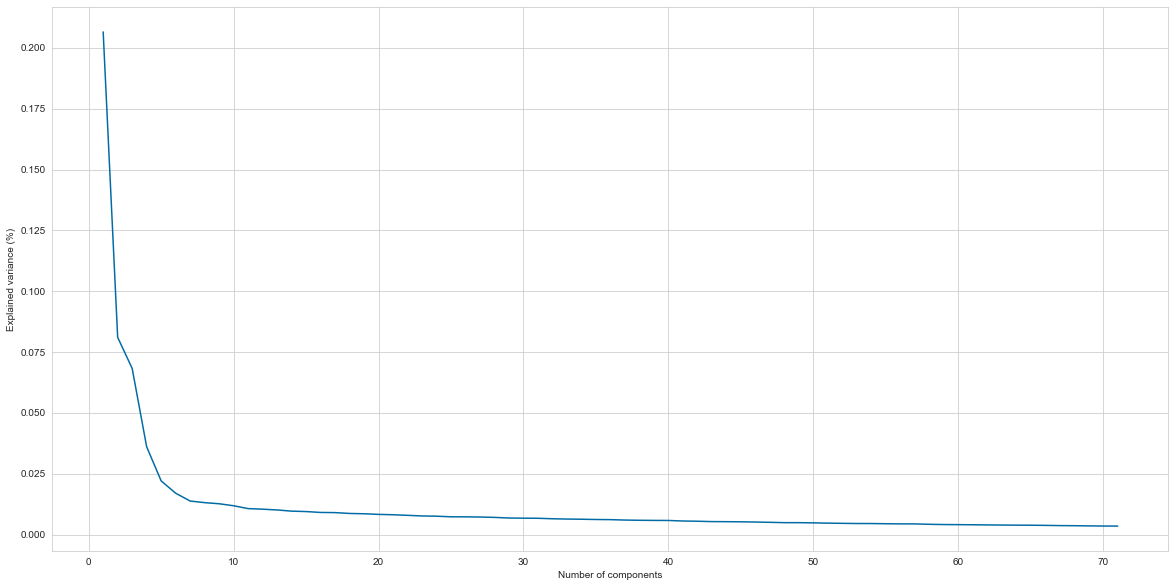

In [50]:
# Make the scree plot
plt.plot(range(1, components + 1), mypca.explained_variance_ratio_ )
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

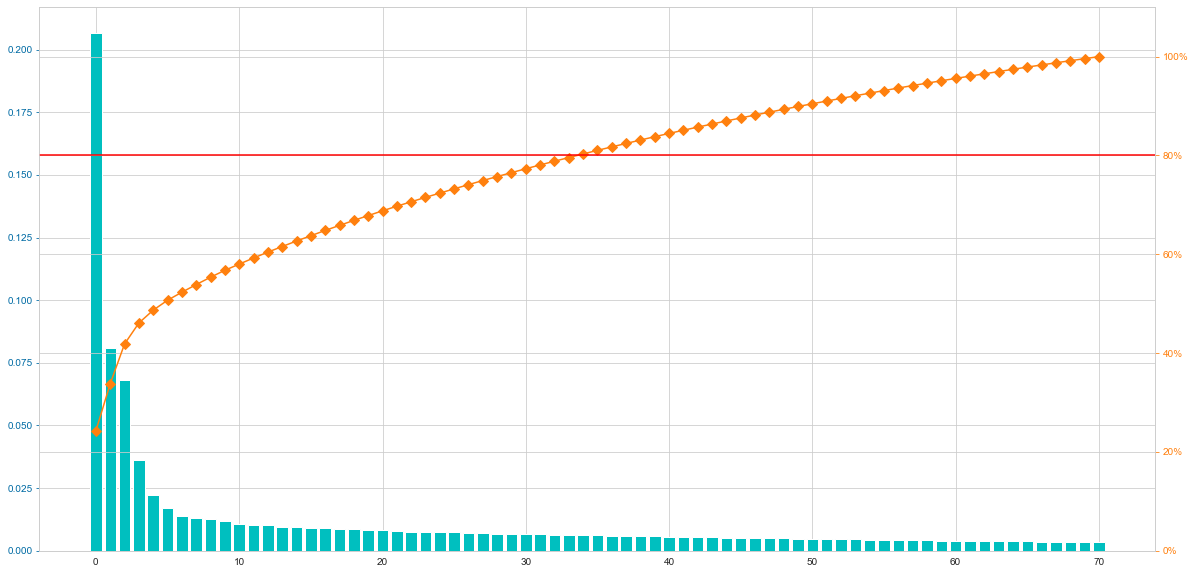

In [58]:
pareto(mypca.explained_variance_ratio_)

In [57]:
sys.append('/Users/gnabeyeuemmanuel/Desktop/demandEstimate/demand-service/Modele_Atemporel_PCA_produit_par_magasin ')

AttributeError: module 'sys' has no attribute 'append'

### Data Pre-processing for Machine Learning

In [105]:
df['date'] = pd.to_datetime(df_q2.date, format='%Y-%m-%d')
X= pd.concat([
    df['date'].dt.day,
    df['date'].dt.weekday,
    df['date'].dt.weekofyear,
],axis=1).drop_duplicates()
X.columns=['day','weekday','weekofyear']
X

,day,weekday,weekofyear
0,1,5,52
629,6,4,18
630,7,5,18
631,8,6,18
632,9,0,19
...,...,...,...
551,17,3,7
552,18,4,7
553,19,5,7
554,20,6,7


In [106]:
table2.shape

(168, 501)

### Splitting the data into Training and Testing sample¶

In [107]:
import math
def normalize(y_train):  
    # Choose between standardization and MinMAx normalization
    scaler=StandardScaler()
    # Storing the fit object for later reference
    scaler=scaler.fit(y_train)
    # Generating the standardized values of X
    yhat=scaler.transform(y_train)
    return yhat, scaler

def split(X,test_size=0.2,n_pca=20):
    n=X.shape[0]
    m=table2.shape[0]
    X_train=X[0:math.floor((1-test_size)*n)]
    X_test=X[math.floor((1-test_size)*n):n+1]
    
    y_train=table2[0:math.floor((1-test_size)*m)]
    y_test=table2[math.floor((1-test_size)*m):m+1]
    
    ## Normalisation 
    yhat, scaler= normalize(y_train)
    ##pca sur les données les sorties d'entrainements.
    mypca=PCA(n_components= n_pca)
    Composantes_principales=mypca.fit_transform(yhat)
    columns=['PC'+str(i) for i in range(n_pca)]
    y_train=pd.DataFrame(data=Composantes_principales,columns=columns)
    
    return X_train,X_test,y_train,y_test,scaler,mypca



### Standardization/Normalization of data

#### Brute force regression

In [150]:
n=X.shape[0]
m=table2.shape[0]
X_train=X[0:math.floor((1-test_size)*n)]
X_test=X[math.floor((1-test_size)*n):n+1]
    
y_train=table2[0:math.floor((1-test_size)*m)]
y_test=table2[math.floor((1-test_size)*m):m+1]

# Choose between standardization and MinMAx normalization
scaler=StandardScaler()
# Storing the fit object for later reference
scaler=scaler.fit(y_train)
# Generating the standardized values of X
y_train=scaler.transform(y_train)    

In [151]:
# Multiple Linear Regression 
RegModel = LinearRegression()

# Printing all the parameters of Linear regression
print(RegModel)

# Creating the model on Training Data
LREG=RegModel.fit(X_train,y_train)
prediction=LREG.predict(X_test)
preds=scaler.inverse_transform(prediction)
print(LREG.coef_)
# Measuring Goodness of fit in Training data
print('R2 Value or determination coefficient:',metrics.r2_score(y_train, LREG.predict(X_train)))

bf_reg=metrics_(y_test,preds)

LinearRegression()
[[ 0.          0.          0.        ]
 [ 0.08167761  0.01955371 -0.32120359]
 [-0.0437752  -0.17035449 -0.05422621]
 ...
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
R2 Value or determination coefficient: 0.3651016291817254


In [152]:
bf_reg

{'MSE': 33.249800917497, 'MAE': 2.785581041422982, 'MSLE': 0.656235409298351}

In [108]:
# Choose between standardization and MinMAx normalization
#PredictorScaler=MinMaxScaler()
PredictorScaler=StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)

# Generating the standardized values of X
X=PredictorScalerFit.transform(X)

### Implementation of the prediction model on the selected components
### PCA Inversion (Transform data back to its original space.)

In [109]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [110]:
def metrics_(orig,preds):
    MSE=mean_squared_error(y_true=orig,
                   y_pred=preds)
    MAE=mean_absolute_error(y_true=orig,
                   y_pred=preds)
    MSLE=mean_squared_log_error(y_true=np.abs(orig),
                   y_pred=np.abs(preds))
    metrics = dict()
    metrics['MSE']= MSE
    metrics['MAE']= MAE
    metrics['MSLE']= MSLE
    return metrics

In [73]:
algo = {'lin_reg': lin_reg,
        'xgb': xgb,
        'RandForest': RandForest
       }

NameError: name 'lin_reg' is not defined

### Simple Average

In [111]:
df_q2=df_q2.sort_values('date')
test_size=0.2
l=math.floor((1-test_size)*df_q2.shape[0])  
tab1=df_q2.loc[:l, ['product_id', 'product_count','category']].groupby(['product_id','category']).mean().reset_index()
tab1

,product_id,category,product_count
0,5cebfa8d0b259700045dc8a9,epicerie_sucree,0.000000
1,5cebfa8d0b259700045dc8aa,epicerie_sucree,0.202123
2,5cebfa8d0b259700045dc8ad,epicerie_sucree,0.141931
3,5cebfa8d0b259700045dc8b1,epicerie_sucree,0.000000
4,5cebfa8d0b259700045dc8b2,epicerie_sucree,0.098570
...,...,...,...
468,623c76f92b1e3e0016f3f533,epicerie_sucree,0.190840
469,623c7c738ce5040016dd02c3,epicerie_sucree,0.123188
470,623c7e312b1e3e0016f3f617,epicerie_sucree,0.134328
471,624565017642eb0016cb4c8a,boissons,0.500000


In [112]:
res = df_q2.loc[l:].merge(tab1, on=['product_id','category'], how='right').fillna({'product_count_y':0}).dropna()
res

,date,product_id,category,product_count_x,product_count_y
0,2022-04-26,5cebfa8d0b259700045dc8a9,epicerie_sucree,0.0,0.000000
1,2022-04-27,5cebfa8d0b259700045dc8a9,epicerie_sucree,0.0,0.000000
2,2022-04-28,5cebfa8d0b259700045dc8a9,epicerie_sucree,0.0,0.000000
3,2022-04-29,5cebfa8d0b259700045dc8a9,epicerie_sucree,0.0,0.000000
4,2022-04-30,5cebfa8d0b259700045dc8a9,epicerie_sucree,0.0,0.000000
...,...,...,...,...,...
371838,2022-06-17,624bfaca171cc3001670b13b,boissons,0.0,0.438776
371839,2022-06-17,624bfaca171cc3001670b13b,boissons,0.0,0.438776
371840,2022-06-17,624bfaca171cc3001670b13b,boissons,0.0,0.438776
371841,2022-06-17,624bfaca171cc3001670b13b,boissons,0.0,0.438776


In [143]:
sa_m=metrics_(res['product_count_x'],res['product_count_y'])
sa_m

{'MSE': 0.5229313123943574,
 'MAE': 0.4469047720689178,
 'MSLE': 0.13489869128442036}

#### Normalize Pandas Dataframe With the mean Normalization

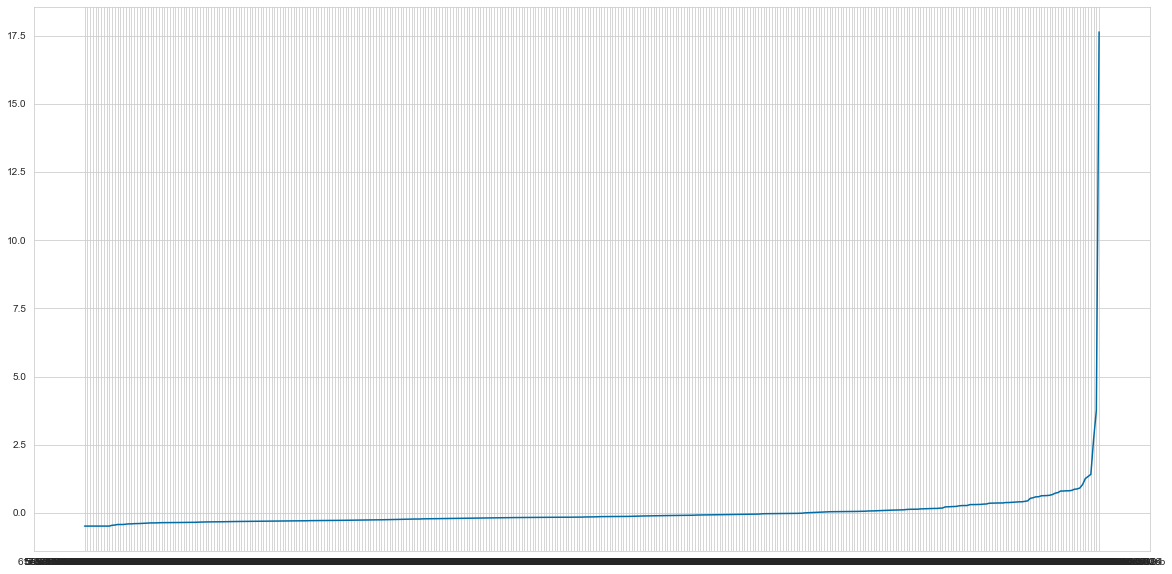

In [114]:
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

h=pd.DataFrame(tab.sort_values('product_count')['product_count'])

h_mean_norm = mean_norm(h)
plt.plot(h_mean_norm)



#### Multiple Linear regression

In [115]:
def lin_reg(n_pca):
    X_train,X_test,y_train,y_test,myscaler,mypca=split(X,test_size=0.2,n_pca=n_pca)
    # Multiple Linear Regression 
    RegModel = LinearRegression()

    # Printing all the parameters of Linear regression
    print(RegModel)

    # Creating the model on Training Data
    LREG=RegModel.fit(X_train,y_train)
    prediction=LREG.predict(X_test)
    preds=myscaler.inverse_transform(mypca.inverse_transform(prediction))
    # Measuring Goodness of fit in Training data
    print('R2 Valuefor n_pca=: %i' % n_pca ,metrics.r2_score(y_train, LREG.predict(X_train)))


    metrics_hist=metrics_(y_test,preds)
    return preds,metrics_hist #,LREG



#### Type arbre boosté: XgBoost

In [116]:
def xgb(n_pca):
    X_train,X_test,y_train,y_test,myscaler,mypca=split(X,test_size=0.2,n_pca=n_pca)
    RegModel=XGBRegressor(max_depth=3, 
                          learning_rate=0.1, 
                          n_estimators=1000, 
                          objective='reg:squarederror',
                          booster='gbtree')

    # Creating the model on Training Data
    XGB=RegModel.fit(X_train,y_train)
    prediction=XGB.predict(X_test) 
    preds=myscaler.inverse_transform(mypca.inverse_transform(prediction))
    
    # Measuring Goodness of fit in Training data 'MSE: %.3f' % MSE
    print('R2 Value for n_pca=: %i' % n_pca,metrics.r2_score(y_train, XGB.predict(X_train)))
    
    metrics_hist=metrics_(y_test,preds)
    return preds,metrics_hist #,XGB

##### Type Bagging: Randon Forest

In [117]:
# Random Forest (Bagging of multiple Decision Trees)  with GridSearch
def RandForest(n_pca):
    X_train,X_test,y_train,y_test,myscaler,mypca=split(X,test_size=0.2,n_pca=n_pca)
    
    # Define Parameters
    max_depth=[2, 8, 16]
    n_estimators = [64, 100, 128]
    param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

    # Build the grid search
    dfrst = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
    grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5)
    
    # Creating the model on Training Data
    grid_results = grid.fit(X_train, y_train)
    
    # Extract the best decision forest 
    best_clf = grid_results.best_estimator_
   
    # Printing all the parameters of Random Forest
    print(best_clf)

    prediction=best_clf.predict(X_test)
    
    ##inversion de pca et de la normalisation
    preds=myscaler.inverse_transform(mypca.inverse_transform(prediction))

    # Measuring Goodness of fit in Training data 'MSE: %.3f' % MSE
    print('R2 Value for train_set and n_pca=: %i' % n_pca,metrics.r2_score(y_train,  best_clf.predict(X_train)))
    print('R2 Value for test_set and n_pca=: %i' % n_pca,metrics.r2_score(y_test, preds))
    
    metrics_hist=metrics_(y_test,preds)
    return preds,metrics_hist #,  best_clf

In [119]:
mon_dico ={"Model1":[],"MSE":[],"MAE":[], "MSLE":[]}
for n_pca in [5,10,20,50,100]:
    preds,metriq=lin_reg(n_pca)
    mon_dico['Model1'].append('lin_reg')
    mon_dico["MSE"].append(metriq["MSE"])
    mon_dico["MAE"].append(metriq["MAE"])
    mon_dico["MSLE"].append(metriq["MSLE"])
m1=pd.DataFrame(mon_dico ,index = [5,10,20,50,100])
m1

LinearRegression()
R2 Valuefor n_pca=: 5 0.07271909137423067
LinearRegression()
R2 Valuefor n_pca=: 10 0.06556451732676702
LinearRegression()
R2 Valuefor n_pca=: 20 0.045080739561293465
LinearRegression()
R2 Valuefor n_pca=: 50 0.030425482778060883
LinearRegression()
R2 Valuefor n_pca=: 100 0.02499317870891687


,Model1,MSE,MAE,MSLE
5,lin_reg,33.675853,2.779990,0.650154
10,lin_reg,33.536017,2.784883,0.655619
20,lin_reg,33.440211,2.784376,0.656256
50,lin_reg,33.373261,2.785916,0.655481
100,lin_reg,33.259477,2.783382,0.655729


In [120]:
mon_dico ={"Model2":[],"MSE":[],"MAE":[], "MSLE":[]}
for n_pca in [5,10,20,50,100]:
    preds,metriq=xgb(n_pca)
    mon_dico['Model2'].append('xgb')
    mon_dico ["MSE"].append(metriq["MSE"])
    mon_dico ["MAE"].append(metriq["MAE"])
    mon_dico ["MSLE"].append(metriq["MSLE"])
m2=pd.DataFrame(mon_dico ,index = [5,10,20,50,100])
m2

R2 Value for n_pca=: 5 0.9946174606848363
R2 Value for n_pca=: 10 0.9931640247278347
R2 Value for n_pca=: 20 0.9884891186121413
R2 Value for n_pca=: 50 0.9882450322648046
R2 Value for n_pca=: 100 0.9873385634470223


,Model2,MSE,MAE,MSLE
5,xgb,26.575191,2.469706,0.583476
10,xgb,27.136785,2.510876,0.600976
20,xgb,27.327961,2.543939,0.605311
50,xgb,28.641738,2.657166,0.640964
100,xgb,30.202627,2.737363,0.658076


In [121]:
mon_dico ={"Model3":[],"MSE":[],"MAE":[], "MSLE":[]}
for n_pca in [5,10,20,50,100]:
    preds,metriq=RandForest(n_pca)
    mon_dico['Model3'].append('RandForest')
    mon_dico ["MSE"].append(metriq["MSE"])
    mon_dico ["MAE"].append(metriq["MAE"])
    mon_dico ["MSLE"].append(metriq["MSLE"])
m3=pd.DataFrame(mon_dico ,index = [5,10,20,50,100])
m3

RandomForestRegressor(max_depth=16)
R2 Value for train_set and n_pca=: 5 0.9015276155245366
R2 Value for test_set and n_pca=: 5 -6.7713994270055444e+28
RandomForestRegressor(max_depth=2)
R2 Value for train_set and n_pca=: 10 0.16248204683860049
R2 Value for test_set and n_pca=: 10 -7.355663521726335e+28
RandomForestRegressor(max_depth=2)
R2 Value for train_set and n_pca=: 20 0.09709286423891067
R2 Value for test_set and n_pca=: 20 -8.317651091408609e+28
RandomForestRegressor(max_depth=2, n_estimators=64)
R2 Value for train_set and n_pca=: 50 0.047786548931041166
R2 Value for test_set and n_pca=: 50 -8.61835433447284e+28
RandomForestRegressor(max_depth=2, n_estimators=64)
R2 Value for train_set and n_pca=: 100 0.028253469457921745
R2 Value for test_set and n_pca=: 100 -9.15118008119027e+28


,Model3,MSE,MAE,MSLE
5,RandForest,25.802692,2.367857,0.573929
10,RandForest,25.578078,2.363437,0.563697
20,RandForest,25.619222,2.368789,0.565781
50,RandForest,25.521189,2.359029,0.562896
100,RandForest,25.510922,2.354839,0.564138


In [144]:
sa_m=pd.DataFrame([sa_m])
sa_m['Model']='Simple_Average'
sa_m.set_index('Model', inplace = True)

,MSE,MAE,MSLE
Model,,,
Simple_Average,0.522931,0.446905,0.134899


In [153]:
bf_reg=pd.DataFrame([bf_reg])
bf_reg['Model4']='BruteForceRegressor'
bf_reg.set_index('Model4', inplace = True)

In [154]:
frames=(bf_reg,m1, m2, m3,sa_m)
m= pd.concat(frames).reset_index()

In [155]:
m['Model'] = m['Model1'].fillna(m['Model2']).fillna(m['Model3']).fillna(m['index'])
m = m.set_index(['Model','index']).drop(['Model1','Model2','Model3'],axis=1)
m

MSE       MAE      MSLE
Model               index                                             
BruteForceRegressor BruteForceRegressor  33.249801  2.785581  0.656235
lin_reg             5                    33.675853  2.779990  0.650154
                    10                   33.536017  2.784883  0.655619
                    20                   33.440211  2.784376  0.656256
                    50                   33.373261  2.785916  0.655481
                    100                  33.259477  2.783382  0.655729
xgb                 5                    26.575191  2.469706  0.583476
                    10                   27.136785  2.510876  0.600976
                    20                   27.327961  2.543939  0.605311
                    50                   28.641738  2.657166  0.640964
                    100                  30.202627  2.737363  0.658076
RandForest          5                    25.802692  2.367857  0.573929
                    10                   25.578078  2.363437  0.563697
                    20                   25.619222  2.368789  0.565781
                    50                   25.521189  2.359029  0.562896
                    100                  25.510922  2.354839  0.564138
Simple_Average      Simple_Average        0.522931  0.446905  0.134899

In [156]:
m_ = m/m.iloc[-1]
m_.style.background_gradient(cmap='cividis')

### Deployment of the Model

#### Prediction function

In [61]:
def FunctionPredictResult(InputData):
    ## InputData being a sequence of date
    InputData['date'] = pd.to_datetime(InputData.date, format='%Y-%m-%d')
    X= pd.concat([
        InputData['date'].dt.day,
        InputData['date'].dt.weekday,
        InputData['date'].dt.weekofyear,
    ],axis=1).drop_duplicates()
    X.columns=['day','weekday','weekofyear']
    
    #PredictorScalerFit,PredictionModel=     ##PredictionModel=RegModel.fit(X,y)
    
    # Generating the standardized values of X since it was done while model training also
    X=PredictorScalerFit.transform(X)

    # Genrating Predictions
    Prediction=PredictionModel.predict(X)
    PredictionResult=pd.DataFrame(Prediction, columns=['Prediction'])
    return(PredictionResult)

In [ ]:
# Calling the function for some loan applications
start_date="2022-20-06", end_date="2022-20-07"
data=pd.date_range(start=start_date, end=end_date)
NewSampleData=pd.DataFrame(data=data,
                           columns=['date'])

print(NewSampleData)

# Calling the Function for prediction
FunctionPredictResult(InputData= NewSampleData)